<a href="https://colab.research.google.com/github/abdishifa234/DS-Unit-2-Applied-Modeling/blob/master/module2-wrangle-ml-datasets/LS_DS_232_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets

- [ ] Continue to clean and explore your data. 
- [ ] For the evaluation metric you chose, what score would you get just by guessing?
- [ ] Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [3]:
#import our tools here
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
cf.go_offline()

In [5]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [6]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [7]:
!pip install gdown

In [8]:
!gdown https://drive.google.com/uc?id=1y0TtYEjkkyuEczM-Jgu6FQfHv1PxOfVG

Downloading...
From: https://drive.google.com/uc?id=1y0TtYEjkkyuEczM-Jgu6FQfHv1PxOfVG
To: /content/archive.zip
15.5MB [00:00, 58.7MB/s]


In [9]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: 2014_Financial_Data.csv  
  inflating: 2015_Financial_Data.csv  
  inflating: 2016_Financial_Data.csv  
  inflating: 2017_Financial_Data.csv  
  inflating: 2018_Financial_Data.csv  


In [10]:
#I have a five year dataset for the display purpose lets read
# Upload datasets and check their shape
pd.options.display.float_format = '{:,.0f}'.format
df_2014 = pd.read_csv('/content/2014_Financial_Data.csv')
df_2015 = pd.read_csv('/content/2015_Financial_Data.csv')
df_2016 = pd.read_csv('/content/2016_Financial_Data.csv')
df_2017 = pd.read_csv('/content/2017_Financial_Data.csv')
df_2018 = pd.read_csv('/content/2018_Financial_Data.csv')

df_2014.shape,df_2015.shape,df_2016.shape,df_2017.shape,df_2018.shape

((3808, 225), (4120, 225), (4797, 225), (4960, 225), (4392, 225))

In [12]:
#write a function that rangles the dataframes
def wrangle(x):
  
  #removing extrem outliers 
  # q_low = x[col].quantile(0.01)
  # q_hi  = x[col].quantile(0.99)
  # x = train[(x[col] < q_hi) & (train[col] > q_low)]

  #renaming the 'Unamed:0' column
  x.rename(columns={'Unnamed: 0':'Company Name'},inplace=True)
  #replacing nan values with zero
  x.replace(np.nan, 0)

  x.drop(x[x['Total assets'] ==0].index, inplace = True) 
  x.drop(x[x['Revenue'] ==0].index, inplace = True) 

  # feature enginering to creat meaningful featutes that determenes stock price
  x['Total Asset Turnover Ratio'] = x['Revenue'] / x['Total assets']
  x['Gross Margin Ratio'] = x['Gross Margin'] / x['Revenue']
  x['Net Profit Ratio'] = x['Net Profit Margin']/x['Revenue']
  x['Return on Total Assets Ratio'] = x['Net Income']/x['Total assets']

  #feature selection
  features = ['Company Name', 'currentRatio','quickRatio', 'Free Cash Flow margin','debtRatio', 'debtEquityRatio',
              'cashFlowToDebtRatio','Return on Tangible Assets','Total Asset Turnover Ratio',
              'Return on Total Assets Ratio','ROE','Gross Margin Ratio',
              'Net Profit Ratio', 'EPS','EPS Diluted','PE ratio', 'PB ratio','priceEarningsToGrowthRatio', 'Sector','Class']
  x = x[features]

  return x

In [13]:
#lets wrangle each dataset and rename our targets which is PriceVar[%]
df2018 = wrangle(df_2018)
df2018['StockPriceVar'] = df_2018['2019 PRICE VAR [%]']
df2017 = wrangle(df_2017)
df2017['StockPriceVar'] = df_2017['2018 PRICE VAR [%]']
df2016 = wrangle(df_2016)
df2016['StockPriceVar'] = df_2016['2017 PRICE VAR [%]']
df2015 = wrangle(df_2015)
df2015['StockPriceVar'] = df_2015['2016 PRICE VAR [%]']
df2014 = wrangle(df_2014)
df2014['StockPriceVar'] = df_2014['2015 PRICE VAR [%]']
df2018.shape, df2017.shape, df2016.shape, df2015.shape, df2014.shape

((4194, 21), (4756, 21), (4588, 21), (3940, 21), (3637, 21))

#Begin to clean and explore your data.

In [14]:
#lets arrange our train,val and testing dataset

#use 2014 to 2016 data for training
train = pd.concat([df2014,df2015,df2016],sort=False).drop_duplicates().sample(frac=1)


#use 2017 data for validation
val=df2017


#use 2017 data for validation
test=df2018


#lets check the shape of our train,val and test dataset
train.shape,val.shape,test.shape

((12165, 21), (4756, 21), (4194, 21))

#Continue to clean and explore your data. 

In [15]:
#lets start exploring our data
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

So from the above summary the big problems we have is missing data,skeweness and so many zero values.but we have to fix skewed data by removing outliers we better impute missing values by some averages using sciktlearn imputer and for now lets handle only the outliers

#EDA for numeric featutes and targets

In [ ]:
# #lets remove the outliers using quantile
# col=['Company Name','Sector','currentRatio', 'quickRatio', 'Free Cash Flow margin',
#        'debtRatio', 'debtEquityRatio', 'cashFlowToDebtRatio',
#        'Return on Tangible Assets', 'Total Asset Turnover Ratio',
#        'Return on Total Assets Ratio', 'ROE', 'Gross Margin Ratio',
#        'Net Profit Ratio', 'EPS', 'EPS Diluted', 'PE ratio', 'PB ratio',
#        'priceEarningsToGrowthRatio', 'Class', 'StockPriceVar']



# q_low = train[col].quantile(0.01)
# q_hi  = train[col].quantile(0.99)
# train = train[(train[col] < q_hi) & (train[col] > q_low)]
# train.shape

In [ ]:
# #I am trying to fix outliers using interqurtile range
# def fixoutliers(x):
#   xColumnNames=x.columns
# #for j in df2ColumnNames:

#   for j in xColumnNames:
#     try:
#         # xy=x[j]    
#         mydata=pd.DataFrame()
#         updated=[]
#         Q1,Q3=np.percentile(xy,[25,75])
#         IQR=Q3-Q1
#         minimum=Q1-1.5*IQR
#         maximum=Q3+1.5*IQR
#         for i in xy:
#             if(i>maximum):
#                 print("Entering maxim")
#                 i=maximum
#                 updated.append(i)
#             elif(i<minimum):
#                 print("enterinf minimum")
#                 i=minimum
#                 updated.append(i)
#             else:
#                 updated.append(i)
#         x[j]=updated
#     except:
#         continue
#   return x

In [ ]:
# #ok remove extrem values and check outliers
# print(train.shape,val.shape,test.shape)
# fixoutliers(train)
# fixoutliers(val)
# fixoutliers(test)

#EDA for categorical features

In [16]:
#lets check how many companies we have
train['Company Name'].value_counts().sum()

12165

In [17]:
# check the distribution of sector column
train['Sector'].value_counts(ascending=False)

Financial Services        2632
Technology                1808
Industrials               1579
Healthcare                1495
Consumer Cyclical         1431
Basic Materials            720
Real Estate                713
Energy                     689
Consumer Defensive         532
Utilities                  305
Communication Services     261
Name: Sector, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



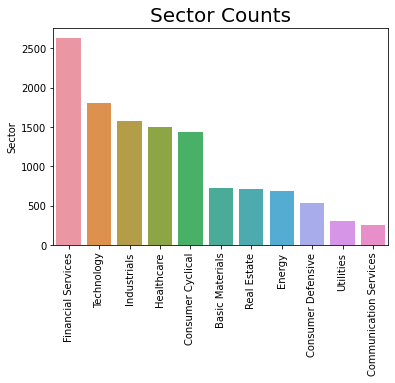

In [18]:
# Plot sector distribution
train_sector = train['Sector'].value_counts()
sns.barplot(np.arange(len(train_sector)), train_sector)
plt.xticks(np.arange(len(train_sector)), train_sector.index.values.tolist(), rotation=90)
plt.title('Sector Counts', fontsize=20)
plt.show()

In [ ]:
# counting the number of stocks by Sector
print(train.groupby(train['Sector']).count().reset_index())

                    Sector  Company Name  ...  Class  StockPriceVar
0          Basic Materials           720  ...    720            720
1   Communication Services           261  ...    261            261
2        Consumer Cyclical          1431  ...   1431           1431
3       Consumer Defensive           532  ...    532            532
4                   Energy           689  ...    689            689
5       Financial Services          2632  ...   2632           2632
6               Healthcare          1495  ...   1495           1495
7              Industrials          1579  ...   1579           1579
8              Real Estate           713  ...    713            713
9               Technology          1808  ...   1808           1808
10               Utilities           305  ...    305            305

[11 rows x 21 columns]


#lets do some financial analysis on one company,AAPL

In [19]:
# Take Apple as an example
df2014AAPL = df2014[df2014['Company Name'] =='AAPL' ]
df2015AAPL = df2015[df2015['Company Name'] =='AAPL' ]
df2016AAPL = df2016[df2016['Company Name'] =='AAPL' ]
df2017AAPL = df2017[df2017['Company Name'] =='AAPL' ]
df2018AAPL = df2018[df2018['Company Name'] =='AAPL' ]

In [20]:
#lets select only apply AAPL
df_AAPL = df2014AAPL.append([df2015AAPL,df2016AAPL,df2017AAPL,df2018AAPL])
list = [2014,2015,2016,2017,2018]
df_AAPL.insert(0,'Year',list)
df_AAPL.replace(np.nan, 0)
df_AAPL.index = [0,1,2,3,4]
df_AAPL.head()

,Year,Company Name,currentRatio,quickRatio,Free Cash Flow margin,debtRatio,debtEquityRatio,cashFlowToDebtRatio,Return on Tangible Assets,Total Asset Turnover Ratio,Return on Total Assets Ratio,ROE,Gross Margin Ratio,Net Profit Ratio,EPS,EPS Diluted,PE ratio,PB ratio,priceEarningsToGrowthRatio,Sector,Class,StockPriceVar
0,2014,AAPL,1,1,0,0,0,2,2,1,0,0,0,0,6,6,15,5,14,Technology,0,-2
1,2015,AAPL,1,1,0,0,1,1,2,1,0,0,0,0,9,9,12,5,11,Technology,1,12
2,2016,AAPL,1,1,0,0,1,1,1,1,0,0,0,0,8,8,14,5,13,Technology,1,48
3,2017,AAPL,1,1,0,0,1,1,1,1,0,0,0,0,9,9,17,6,16,Technology,0,-7
4,2018,AAPL,1,1,0,0,1,1,1,1,0,1,0,0,12,12,19,10,19,Technology,1,89


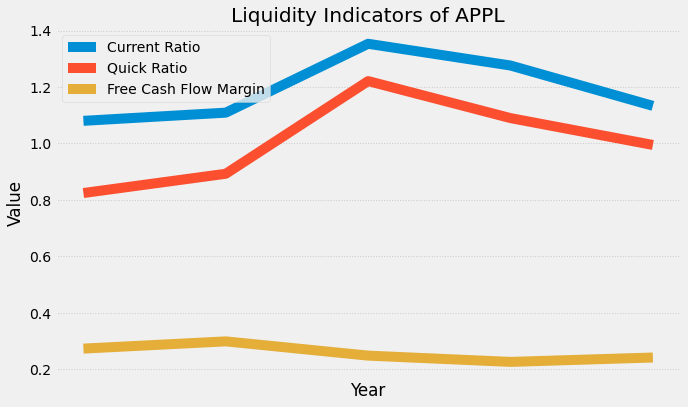

In [21]:
#Lets plot liquidity indicators for APPL
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 6
plt.style.use('fivethirtyeight')
plt.title('Liquidity Indicators of APPL')
plt.grid(True, linestyle=':')
plt.xticks([2014,2015,2016,2017,2018])
plt.xlabel('Year')
plt.ylabel('Value')
plt.plot(df_AAPL['currentRatio'],label='Current Ratio',linewidth=10)
plt.plot(df_AAPL['quickRatio'],label='Quick Ratio',linewidth=10)
plt.plot(df_AAPL['Free Cash Flow margin'],label='Free Cash Flow Margin',linewidth=10)
plt.legend(loc=2);

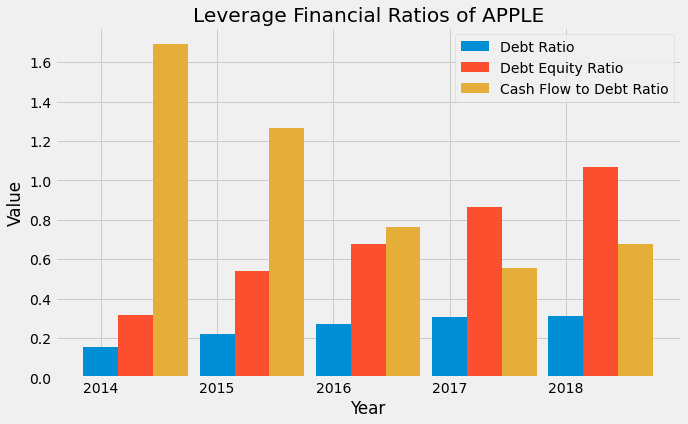

In [22]:
#lets plot the financial leverage for APPL
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 10, 6
pos = np.arange(len(df_AAPL))
year = [2014,2015,2016,2017,2018]
plt.bar(pos,df_AAPL['debtRatio'],width = 0.3, label='Debt Ratio')
plt.bar(pos+0.3,df_AAPL['debtEquityRatio'],width = 0.3,label='Debt Equity Ratio')
plt.bar(pos+0.6,df_AAPL['cashFlowToDebtRatio'],width = 0.3,label='Cash Flow to Debt Ratio')
plt.xlabel('Year')
plt.ylabel('Value')
plt.xticks(pos,year)
plt.title('Leverage Financial Ratios of APPLE')
plt.legend();

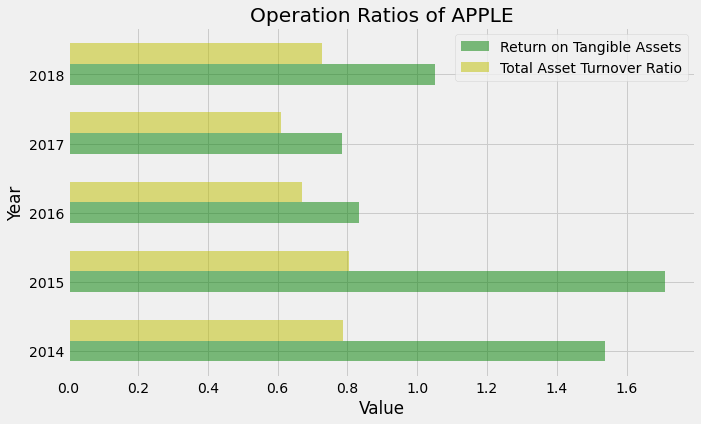

In [23]:
#lets also plot the operations ratio of apple
pos = np.arange(len(df_AAPL))
year = [2014,2015,2016,2017,2018]
plt.barh(pos,df_AAPL['Return on Tangible Assets'],height =0.3,alpha=0.5,color='g', label='Return on Tangible Assets')
plt.barh(pos+0.3,df_AAPL['Total Asset Turnover Ratio'],height =0.3,alpha=0.5,color='y', label='Total Asset Turnover Ratio')
plt.xlabel('Value')
plt.ylabel('Year')
plt.yticks(pos,year)
plt.title('Operation Ratios of APPLE')
plt.legend();

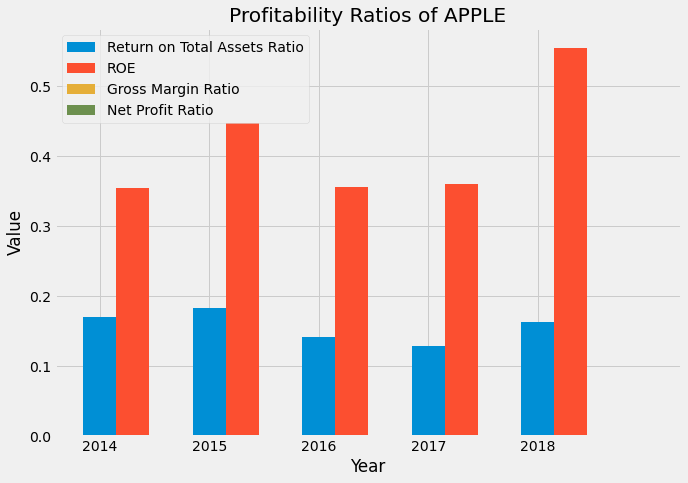

In [24]:
#this is also profitability indicators for APPL from 2014 to 2018
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 10, 7
pos = np.arange(len(df_AAPL))
year = [2014,2015,2016,2017,2018]
plt.bar(pos,df_AAPL['Return on Total Assets Ratio'],width = 0.3, label='Return on Total Assets Ratio')
plt.bar(pos+0.3,df_AAPL['ROE'],width = 0.3,label='ROE')
plt.bar(pos+0.6,df_AAPL['Gross Margin Ratio'],width = 0.3,label='Gross Margin Ratio')
plt.bar(pos+0.9,df_AAPL['Net Profit Ratio'],width = 0.3,label='Net Profit Ratio')
plt.xlabel('Year')
plt.ylabel('Value')
plt.xticks(pos,year)
plt.title('Profitability Ratios of APPLE')
plt.legend(loc='upper left');

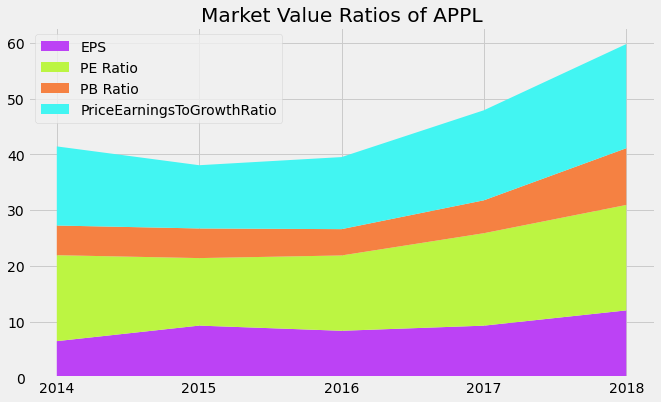

In [25]:
#finally lets plot the market value indicators for AAPL
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title('Market Value Ratios of APPL')
ax.set_xticks([2014,2015,2016,2017,2018])
labels = ['EPS', 'PE Ratio','PB Ratio','PriceEarningsToGrowthRatio']
colors = ['#bc42f5','#bcf542', '#f58142','#42f5f2']
ax.stackplot(df_AAPL['Year'], df_AAPL['EPS'], df_AAPL['PE ratio'], df_AAPL['PB ratio'], df_AAPL['priceEarningsToGrowthRatio'],labels=labels, colors = colors)
ax.legend(loc='upper left')
plt.show()

#For the evaluation metric you chose, what score would you get just by guessing?

For my classification problem,i chose "Class" as my target and the evalution metric i chose is accuracy score for evaluting the success of my model

In [27]:
#Lets start with the baseline
target='Class'
y_train=train[target]

#see our baseline or majority class of the target Class
train['Class'].value_counts()

1    7515
0    4650
Name: Class, dtype: int64

In [28]:
#lets see the baseline accuracy of our prediction
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

# lets calculate the majority class accuracy 
accuracy_score(y_train, y_pred)

0.6177558569667078

#for evaluting the success of the regression problem,I chose MAE and RMSE,R2 for evaluting my regression model

In [29]:
#arranging the y target vectors
target='StockPriceVar'
y_train=train[target]

In [31]:
#Lets make first baseline for our target PRICE VAR[%]
print('Mean baseline(using 0 features)')
baseline=y_train.mean()
y_pred=[baseline]*len(y_train)
print(baseline)

Mean baseline(using 0 features)
477.6306122793981


In [32]:
#lets see the MAE,RMSE and R2 for the baseline
from sklearn.metrics import mean_absolute_error,r2_score
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
mae=mean_absolute_error(y_train,y_pred)
r2 = r2_score(y_train, y_pred)
print(mse)
print(rmse)
print(mae)
print(r2)

678734089.6609808
26052.525590832473
928.821842043746
0.0


#Can you make a fast, first model that beats guessing?

#lets start with regression problem,so our target is Stockprice varation

In [33]:
#lets start by gussing our target
target = 'StockPriceVar'
guess = train[target].mean()
print('{:,.2f}'.format(guess))

477.63


In [34]:
#lets see our errors here
errors = guess - train['StockPriceVar']
mean_absolute_error = errors.abs().mean()
mean_absolute_error

928.8218420437483

In [ ]:
#OK now lets calculate train error
from sklearn.metrics import mean_absolute_error
y_pred=[guess]*len(y_train)
mae=mean_absolute_error(y_train,y_pred)
print(f'Train price variance): {mae:.2f} percentage points')

Train price variance): 928.82 percentage points


In [38]:
#lets arrange our data here
target = 'StockPriceVar'
features = train.columns.drop([target] + ['Company Name','Class','Sector'])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

#check the shape
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((12165, 17), (12165,), (4756, 17), (4756,), (4194, 17), (4194,))

In [39]:
#lets encode,impute and scale our data here
encoder = ce.OrdinalEncoder()
imputer = SimpleImputer()
sc = StandardScaler()

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

X_train_imputed= imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

X_train_scaled= sc.fit_transform(X_train_imputed)
X_val_scaled= sc.transform(X_val_imputed)
X_test_scaled= sc.transform(X_test_imputed)

In [40]:
#instantiate our model
model = LinearRegression()
#fit our model on train set
model.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
#predict on train,val and test sets
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

In [46]:
# from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f'MAE for train set is: {mae_train:,.2f} ')
print(f'MAE for val set is: {mae_val:,.2f} ')
print(f'MAE for test set is: {mae_test:,.2f} ')

TypeError: ignored

In [47]:
r2_train = r2_score(y_train, y_train_pred)
r2_train

1.4969765997574491e-05

#it doesnt look normal 

#Classification problem our target is 'Class' column

In [54]:
#lets arrange our data here
target = 'Class'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

#check the shape
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4588, 20), (4588,), (4756, 20), (4756,), (4194, 20), (4194,))

In [55]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100,max_depth=40,min_samples_leaf=30,oob_score=True,
                           verbose=0,bootstrap=True,criterion='entropy',
                           warm_start=True,random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 1.0
Validation Accuracy 1.0


#Over fitting becouse of leakage